# Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import keras 
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn import decomposition, metrics, pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D,GlobalAveragePooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D,concatenate
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
plt.style.use('seaborn')
stop_words = stopwords.words('english')

# Data preprocesing and cleaning


In [4]:
#importing the data
df=pd.read_csv('flipkart_com-ecommerce_sample.csv')

In [5]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


In [6]:
# I see some of the some of the data in the product_category_tree column that was not present in tree form
#so i identified the brands and decided to drop that particular data
bad_brands=['Bengal Blooms','Dressberry','Mast & Harbour','K&P','Lilliput','FIFO','Koie','Eternal Gandhi']
df[df.brand.isin(bad_brands)]


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
5,c2a17313954882c1dba461863e98adf2,2016-03-25 22:59:23 +0000,http://www.flipkart.com/eternal-gandhi-super-s...,Eternal Gandhi Super Series Crystal Paper Weig...,"[""Eternal Gandhi Super Series Crystal Paper We...",PWTEB7H2E4KCYUE3,430.0,430.0,"[""http://img5a.flixcart.com/image/paper-weight...",False,Key Features of Eternal Gandhi Super Series Cr...,No rating available,No rating available,Eternal Gandhi,"{""product_specification""=>[{""key""=>""Model Name..."
30,186d40c6852da91166c7eb7856603c51,2016-05-11 09:26:02 +0000,http://www.flipkart.com/bengal-blooms-rose-art...,Bengal Blooms Rose Artificial Plant with Pot,"[""Bengal Blooms Rose Artificial Plant with Po...",ARPEGDHSXZJSHGSN,799.0,579.0,"[""http://img5a.flixcart.com/image/artificial-p...",False,Key Features of Bengal Blooms Rose Artificial ...,No rating available,No rating available,Bengal Blooms,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
328,b0e1a3476567e4836fc9ba36f68a9b99,2016-04-04 16:06:42 +0000,http://www.flipkart.com/dressberry-gold-synthe...,Dressberry Gold Synthetic Clutch,"[""Dressberry Gold Synthetic Clutch""]",CLTEHE9FNRZSJGNB,1299.0,1299.0,"[""http://img6a.flixcart.com/image/clutch/g/n/b...",False,Dressberry Gold Synthetic Clutch Price: Rs. 1...,No rating available,No rating available,Dressberry,"{""product_specification""=>[{""key""=>""Material"",..."
329,77cb6d30d6a472220dfde4d666aa48f0,2016-04-04 16:06:42 +0000,http://www.flipkart.com/mast-harbour-black-syn...,Mast & Harbour Black Synthetic Clutch,"[""Mast & Harbour Black Synthetic Clutch""]",CLTEHE9FHWMCHUMM,1899.0,1899.0,"[""http://img6a.flixcart.com/image/clutch/u/m/m...",False,Mast & Harbour Black Synthetic Clutch Price: ...,No rating available,No rating available,Mast & Harbour,"{""product_specification""=>[{""key""=>""Material"",..."
334,5fd1c9dc5d64e71bbe9d3058dff41864,2016-04-04 16:06:42 +0000,http://www.flipkart.com/dressberry-gold-synthe...,Dressberry Gold Synthetic Clutch,"[""Dressberry Gold Synthetic Clutch""]",CLTEHE9FS4UCYDGH,1299.0,1299.0,"[""http://img6a.flixcart.com/image/clutch/d/g/h...",False,Dressberry Gold Synthetic Clutch Price: Rs. 1...,No rating available,No rating available,Dressberry,"{""product_specification""=>[{""key""=>""Material"",..."
337,f595f5850d12bb0eb5ae39d9a7b848e1,2016-04-04 16:06:42 +0000,http://www.flipkart.com/mast-harbour-black-syn...,Mast & Harbour Black Synthetic Clutch,"[""Mast & Harbour Black Synthetic Clutch""]",CLTEHE9GGXJKCWCV,1899.0,1899.0,"[""http://img5a.flixcart.com/image/clutch/w/c/v...",False,Mast & Harbour Black Synthetic Clutch Price: ...,No rating available,No rating available,Mast & Harbour,"{""product_specification""=>[{""key""=>""Material"",..."
339,6f3826c5a55481b1e987bd0fd4469ea4,2016-04-04 16:06:42 +0000,http://www.flipkart.com/dressberry-black-synth...,Dressberry Black Synthetic Clutch,"[""Dressberry Black Synthetic Clutch""]",CLTEHE9FD2APDRWQ,1299.0,1299.0,"[""http://img5a.flixcart.com/image/clutch/r/w/q...",False,Dressberry Black Synthetic Clutch Price: Rs. ...,No rating available,No rating available,Dressberry,"{""product_specification""=>[{""key""=>""Material"",..."
342,597fc50c8883cfce6b273ba54ee71f5a,2016-04-04 16:06:42 +0000,http://www.flipkart.com/dressberry-black-synth...,Dressberry Black Synthetic Clutch,"[""Dressberry Black Synthetic Clutch""]",CLTEHE9FDPYN5TQ3,1299.0,1299.0,"[""http://img6a.flixcart.com/image/clutch/t/q/3...",False,Dressberry Black Synthetic Clutch Price: Rs. ...,No rating available,No rating available,Dressberry,"{""product_specification""=>[{""key""=>""Material"",..."
343,6a61b755f9c0ea89bac16e677b6a12c6,2016-04-04 16:06:42 +0000,http://www.flipkart.com/mast-harbour-gold-synt...,Mast & Harbour Gold Synthetic Clutch,"[""Mast & Harbour Gold Synthetic Clutch""]",CLTEHE9GYYY2P7AN,1899.0,1899.0,"

In [7]:
# Dropping those rows
df= df[~df['brand'].isin(bad_brands)]

In [81]:
#creating a dataset by dropping the unnecessary columns
df1=df.drop(columns=['uniq_id', 'crawl_timestamp','product_url','retail_price', 'discounted_price', 'image',
                 'is_FK_Advantage_product','product_rating','overall_rating', 'product_specifications', 'brand','pid', 'product_name'])

In [8]:
df1.head()

,product_category_tree,pid,description
0,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,Key Features of Alisha Solid Women's Cycling S...
1,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,FabHomeDecor Fabric Double Sofa Bed (Finish Co...
2,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,Key Features of AW Bellies Sandals Wedges Heel...
3,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,Key Features of Alisha Solid Women's Cycling S...
4,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,Specifications of Sicons All Purpose Arnica Do...


In [82]:
# Creating category column
df1['product_category_tree'] = df1['product_category_tree'].map(lambda x : "".join(i for i in x if not i in ['[', '>', '"', ']']).split("  "))
df1=df1[df1['product_category_tree'].map(len) > 1]
df1['category']=df1['product_category_tree'].map(lambda x: x[0])

In [68]:
df1.head()

,product_category_tree,description,category
0,"[Clothing, Women's Clothing, Lingerie, Sleep &...",Key Features of Alisha Solid Women's Cycling S...,Clothing
1,"[Furniture, Living Room Furniture, Sofa Beds &...",FabHomeDecor Fabric Double Sofa Bed (Finish Co...,Furniture
2,"[Footwear, Women's Footwear, Ballerinas, AW Be...",Key Features of AW Bellies Sandals Wedges Heel...,Footwear
3,"[Clothing, Women's Clothing, Lingerie, Sleep &...",Key Features of Alisha Solid Women's Cycling S...,Clothing
4,"[Pet Supplies, Grooming, Skin & Coat Care, Sha...",Specifications of Sicons All Purpose Arnica Do...,Pet Supplies


In [83]:
#number of unique categiries the data
category=df1['category'].unique()
cat_counts=df1['category'].value_counts()

In [78]:
#As we can see there are 32 unique categories. As we can the there are many categories that have a low count of products,
# So tremove skewness from our data I remove these categories
cat_counts, print(len(cat_counts))

32


(Clothing                             6186
 Jewellery                            3530
 Footwear                             1227
 Mobiles & Accessories                1098
 Automotive                           1012
 Home Decor & Festive Needs            928
 Beauty and Personal Care              710
 Home Furnishing                       700
 Kitchen & Dining                      647
 Computers                             578
 Watches                               530
 Baby Care                             479
 Tools & Hardware                      391
 Toys & School Supplies                330
 Pens & Stationery                     313
 Bags, Wallets & Belts                 264
 Furniture                             180
 Sports & Fitness                      166
 Cameras & Accessories                  82
 Home Improvement                       81
 Health & Personal Care Appliances      43
 Sunglasses                             35
 Gaming                                 35
 Pet Suppli

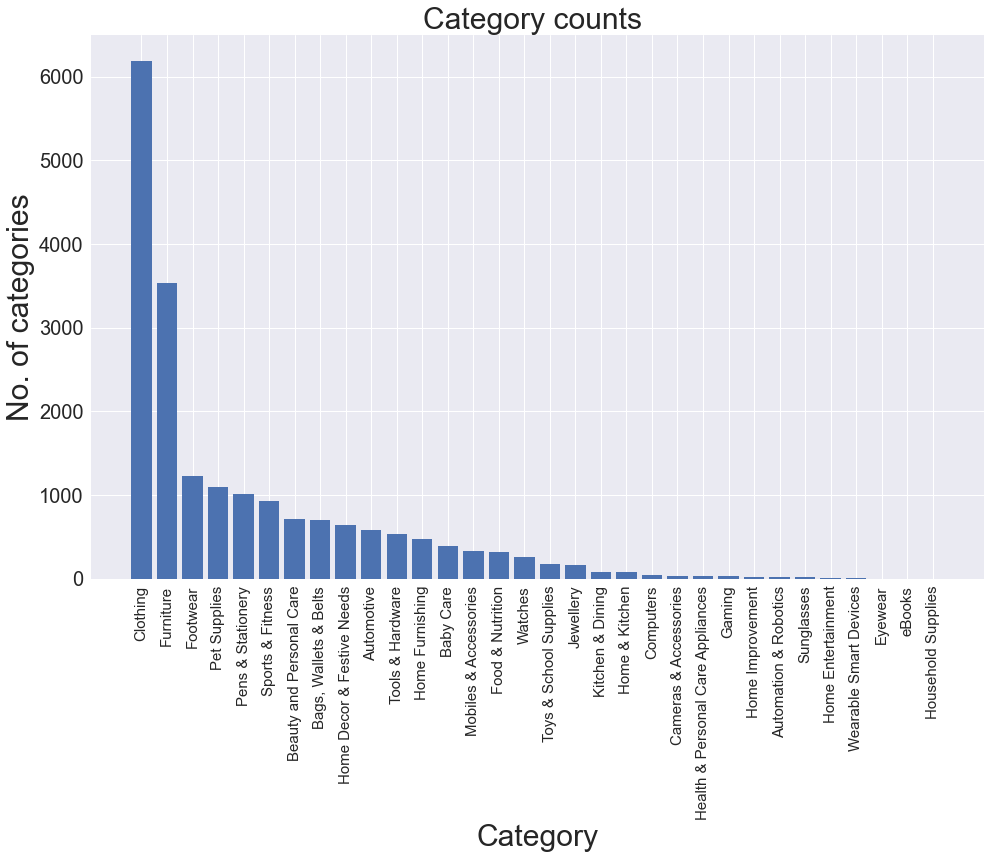

In [785]:
#plotting the category counts
plt.figure(figsize=(16, 10))
plt.bar(category, cat_counts)
#plt.plot(n_days, o,  color='orange')
plt.title('Category counts ', size=30)
plt.xlabel('Category', size=30)
plt.ylabel('No. of categories', size=30)
plt.yticks()
plt.xticks(size=15, rotation=90)
plt.yticks(size=20)
plt.show()

In [84]:
# I remove the categories that have very less representations in the data so as to remove the skewness.
threshold = 25 # Anything that occurs less than this will be removed.
to_remove = cat_counts[cat_counts <= threshold].index
#replacing the data with nan values
df1.replace(to_remove, np.nan, inplace=True)


In [85]:
#total number of null values in the data
df1.isnull().sum()

product_category_tree     0
description               2
category                 77
dtype: int64

In [86]:
#dropping null values
df1=df1.dropna()
df1.reset_index(inplace=True)

In [15]:
df1.head()

,index,product_category_tree,pid,description,category
0,0,"[Clothing, Women's Clothing, Lingerie, Sleep &...",SRTEH2FF9KEDEFGF,Key Features of Alisha Solid Women's Cycling S...,Clothing
1,1,"[Furniture, Living Room Furniture, Sofa Beds &...",SBEEH3QGU7MFYJFY,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,Furniture
2,2,"[Footwear, Women's Footwear, Ballerinas, AW Be...",SHOEH4GRSUBJGZXE,Key Features of AW Bellies Sandals Wedges Heel...,Footwear
3,3,"[Clothing, Women's Clothing, Lingerie, Sleep &...",SRTEH2F6HUZMQ6SJ,Key Features of Alisha Solid Women's Cycling S...,Clothing
4,6,"[Clothing, Women's Clothing, Lingerie, Sleep &...",SRTEH2FVVKRBAXHB,Key Features of Alisha Solid Women's Cycling S...,Clothing


In [88]:
# I take product description as x variable and product cateogry as y variable 
X=df1['description'].values
y=df1['category'].values

In [89]:
print(X.shape)
print(y.shape)

(19573,)
(19573,)


In [91]:
# Encoding the target variable to convert labels into numeric form
enc=LabelEncoder()
y_enc=enc.fit_transform(y)

In [151]:
#Spliting dataset into train and test samples
X_train,X_test,y_train,y_test=train_test_split(X, y_enc, random_state=0, test_size=0.15, shuffle=True)

In [33]:
print(X_train.shape)
print(X_test.shape)

(16515,)
(2915,)


In [93]:
# function for preprocessing the data by tokenizing and stemming.
def tokenize(text):

    filtered_sentence=[] 

    tokenizer=nltk.RegexpTokenizer(r"\w+") 
    word_tokens = tokenizer.tokenize(text)
    
    Stem_words = []
    ps =PorterStemmer()
    for words in word_tokens:
        rootWord=ps.stem(words)
        Stem_words.append(rootWord)
    return Stem_words

In [94]:
#The TfidfVectorizer will tokenize documents,learn the vocabulary and inverse document frequency
# weightings, and allow us to encode new documents. I use uni-grams, bi-grams and tri-grams
tfid_vect = TfidfVectorizer(tokenizer = tokenize, min_df=3,  
            strip_accents='unicode', ngram_range=(1, 3), 
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
# Fitting TfidfVectorizer to both training and test sets 
tfid_vect.fit(X_train)
X_train_tfid=tfid_vect.transform(X_train)
X_test_tfid=tfid_vect.transform(X_test)

C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 

In [159]:
#The CountVectorizer provides a simple way to both tokenize a collection of text documents
#and build a vocabulary of known words, but also to encode new documents using that vocabulary
ctv = CountVectorizer(tokenizer = tokenize,analyzer='word',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets 
ctv.fit(list(X_train) + list(X_test))
X_train_cvect =  ctv.transform(X_train) 
X_test_cvect = ctv.transform(X_test)

In [98]:
#creating modified stopwords
stop_words = stopwords.words('english')
custom_stop_words=['Flipkart.com ','30', 'day', 'replacement','Guarantee', 'Free', 'Shipping', 'Cash', 'On' ,'Delivery', 
                   'free', 'shipping','only', 'geniune','products', 'Key', 'Features',  'Specifications','Buy' ]
modified_stop_words=custom_stop_words+stop_words

In [99]:
#The TfidfVectorizer with modified stopwords 
tfid_vect_mod = TfidfVectorizer(tokenizer = tokenize, min_df=3,  
            strip_accents='unicode', ngram_range=(1, 3), 
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = modified_stop_words)
# Fitting TfidfVectorizer to both training and test sets 
tfid_vect_mod.fit(list(X_train) + list(X_test))
X_train_tfid_mod=tfid_vect_mod.transform(X_train)
X_test_tfid_mod=tfid_vect_mod.transform(X_test)

C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'buy', 'cash', 'com', 'deliveri', 'doe', 'dure', 'featur', 'flipkart', 'geniun', 'guarante', 'ha', 'hi', 'key', 'onc', 'onli', 'ourselv', 'product', 'replac', 'ship', 'specif', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [101]:
#The CountVectorizer using stopwords
ctv_mod = CountVectorizer(tokenizer = tokenize,analyzer='word',
            ngram_range=(1, 3), stop_words = modified_stop_words)

# Fitting Count Vectorizer to both training and test sets 
ctv_mod.fit(list(X_train) + list(X_test))
X_train_cvect_mod =  ctv_mod.transform(X_train) 
X_test_cvect_mod = ctv_mod.transform(X_test)

C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'buy', 'cash', 'com', 'deliveri', 'doe', 'dure', 'featur', 'flipkart', 'geniun', 'guarante', 'ha', 'hi', 'key', 'onc', 'onli', 'ourselv', 'product', 'replac', 'ship', 'specif', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [49]:
#defining log loss function for multiclass predictions 
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [162]:
# Fitting a simple Logistic Regression on TFID datasets. The hyperparamters were tuned and best results were predicted.
lr_classifier = LogisticRegression(C=1.0, multi_class='auto',max_iter=1000)
lr_classifier.fit(X_train_tfid, y_train)
y_pred_tfid_lr = lr_classifier.predict_proba(X_test_tfid)

print ("logloss: %0.3f " % multiclass_logloss(y_test, y_pred_tfid_lr))
print(metrics.classification_report (y_test, np.argmax(y_pred_tfid_lr, axis = 1)))

logloss: 0.242 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       157
           1       1.00      0.76      0.86        67
           2       0.88      0.88      0.88        34
           3       0.96      0.93      0.95       103
           4       1.00      0.93      0.96        14
           5       0.97      1.00      0.99       936
           6       0.96      0.98      0.97        99
           7       0.99      0.99      0.99       168
           8       1.00      0.89      0.94        28
           9       0.89      1.00      0.94       134
          10       0.94      0.96      0.95        96
          11       1.00      0.72      0.84        18
          12       0.99      1.00      0.99       524
          13       0.89      0.96      0.92        96
          14       0.98      0.99      0.98       165
          15       0.97      0.63      0.76        46
          16       0.96      0.72      0.82        32
          1

In [100]:
# Fitting a simple Logistic Regression on TFID datasets wirh modified stopwords.The hyperparamters were tuned and best results were predicted.
lr_classifier = LogisticRegression(C=1.0, multi_class='auto',max_iter=1000)
lr_classifier.fit(X_train_tfid_mod, y_train)
y_pred_tfid_lr = lr_classifier.predict_proba(X_test_tfid_mod)

print ("logloss: %0.3f " % multiclass_logloss(y_test, y_pred_tfid_lr))
print(metrics.classification_report (y_test, np.argmax(y_pred_tfid_lr, axis = 1)))

logloss: 0.268 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       157
           1       1.00      0.73      0.84        67
           2       0.88      0.88      0.88        34
           3       0.97      0.93      0.95       103
           4       1.00      0.93      0.96        14
           5       0.96      1.00      0.98       936
           6       0.97      0.96      0.96        99
           7       0.98      0.99      0.99       168
           8       1.00      0.89      0.94        28
           9       0.89      1.00      0.94       134
          10       0.95      0.96      0.95        96
          11       1.00      0.72      0.84        18
          12       0.99      1.00      1.00       524
          13       0.93      0.97      0.95        96
          14       0.98      0.99      0.98       165
          15       0.97      0.63      0.76        46
          16       0.96      0.75      0.84        32
          1

In [164]:
# Fitting a simple Logistic Regression on Counts datasets .The hyperparamters were tuned and best results were predicted.
lr_classifier = LogisticRegression(C=1.0, multi_class='auto',max_iter=1000)
lr_classifier.fit(X_train_cvect, y_train)
y_pred_cvect_lr = lr_classifier.predict_proba(X_test_cvect)

print ("logloss: %0.3f " % multiclass_logloss(y_test, y_pred_cvect_lr))
print(metrics.classification_report (y_test, np.argmax(y_pred_cvect_lr, axis = 1)))

logloss: 0.086 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       157
           1       0.97      0.85      0.90        67
           2       0.92      0.97      0.94        34
           3       0.98      0.96      0.97       103
           4       1.00      0.93      0.96        14
           5       0.99      1.00      0.99       936
           6       0.98      0.99      0.98        99
           7       1.00      0.99      0.99       168
           8       1.00      0.89      0.94        28
           9       0.96      0.99      0.97       134
          10       0.99      0.97      0.98        96
          11       0.93      0.78      0.85        18
          12       0.99      1.00      1.00       524
          13       0.89      0.98      0.93        96
          14       0.99      0.98      0.99       165
          15       0.92      0.78      0.85        46
          16       0.97      0.91      0.94        32
          1

In [102]:
# Fitting a simple Logistic Regression on Counts datasets modified with stop_words. The hyperparamters were tuned and best results were predicted. 
lr_classifier = LogisticRegression(C=1.0, multi_class='auto', max_iter=1000)
lr_classifier.fit(X_train_cvect_mod, y_train)
y_pred_cvect_lr = lr_classifier.predict_proba(X_test_cvect_mod)

print ("logloss: %0.3f " % multiclass_logloss(y_test, y_pred_cvect_lr))
print(metrics.classification_report (y_test, np.argmax(y_pred_cvect_lr, axis = 1)))

logloss: 0.082 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       157
           1       0.97      0.85      0.90        67
           2       0.92      0.97      0.94        34
           3       0.98      0.97      0.98       103
           4       1.00      0.93      0.96        14
           5       0.99      1.00      0.99       936
           6       0.98      0.99      0.98        99
           7       1.00      0.99      1.00       168
           8       1.00      0.89      0.94        28
           9       0.97      0.99      0.98       134
          10       0.99      0.96      0.97        96
          11       0.93      0.78      0.85        18
          12       0.99      1.00      1.00       524
          13       0.89      0.98      0.93        96
          14       0.99      0.98      0.99       165
          15       0.90      0.80      0.85        46
          16       0.97      0.91      0.94        32
          1

In [166]:
# Apply SVD to preprocess the data for SVM classification.
# On TFIDF data
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(X_train_tfid)
X_train_svd_tfidf = svd.transform(X_train_tfid)
X_test_svd_tfidf = svd.transform(X_test_tfid)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = StandardScaler()
scl.fit(list(X_train_svd_tfidf)+ list(X_test_svd_tfidf))
X_train_svd_tfidf_scl = scl.transform(X_train_svd_tfidf)
X_test_svd_tfidf_scl = scl.transform(X_test_svd_tfidf)

In [167]:
#Fitting SVM  classifier
svm_classifier = SVC(C=1.0, probability=True) # since we need probabilities
svm_classifier.fit(X_train_svd_tfidf_scl, y_train)
y_pred_svm = svm_classifier.predict_proba(X_test_svd_tfidf_scl)

print ("logloss: %0.3f " % multiclass_logloss(y_test, y_pred_svm))
print(metrics.classification_report (y_test, np.argmax(y_pred_svm, axis = 1)))

logloss: 0.154 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       157
           1       0.96      0.66      0.78        67
           2       0.83      0.88      0.86        34
           3       0.93      0.93      0.93       103
           4       1.00      0.93      0.96        14
           5       0.99      0.99      0.99       936
           6       0.94      0.93      0.93        99
           7       0.99      0.99      0.99       168
           8       1.00      0.96      0.98        28
           9       0.88      0.99      0.93       134
          10       0.93      0.98      0.95        96
          11       0.74      0.78      0.76        18
          12       1.00      0.99      0.99       524
          13       0.84      0.93      0.88        96
          14       0.95      0.97      0.96       165
          15       0.85      0.61      0.71        46
          16       0.72      0.72      0.72        32
          1

In [173]:
# Apply SVD to preprocess the data for SVM classification.
# On  count vectorizer datasets
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(X_train_cvect)
X_train_svd_ctv = svd.transform(X_train_cvect)
X_test_svd_ctv = svd.transform(X_test_cvect)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = StandardScaler()
scl.fit(list(X_train_svd_ctv)+ list(X_test_svd_ctv))
X_train_svd_ctv_scl = scl.transform(X_train_svd_ctv)
X_test_svd_ctv_scl = scl.transform(X_test_svd_ctv)

In [174]:
#Fitting SVM  classifier
svm_classifier = SVC(C=1.0, probability=True) # since we need probabilities
svm_classifier.fit(X_train_svd_ctv_scl, y_train)
y_pred_svm = svm_classifier.predict_proba(X_test_svd_ctv_scl)

print ("logloss: %0.3f " % multiclass_logloss(y_test, y_pred_svm))
print(metrics.classification_report (y_test, np.argmax(y_pred_svm, axis = 1)))

logloss: 0.224 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       157
           1       0.92      0.70      0.80        67
           2       0.91      0.85      0.88        34
           3       0.93      0.92      0.93       103
           4       1.00      0.07      0.13        14
           5       0.97      0.99      0.98       936
           6       0.68      0.81      0.74        99
           7       0.88      0.97      0.92       168
           8       1.00      0.82      0.90        28
           9       0.95      0.96      0.96       134
          10       0.91      0.95      0.93        96
          11       0.80      0.44      0.57        18
          12       0.99      0.98      0.99       524
          13       0.74      0.91      0.82        96
          14       0.96      0.88      0.92       165
          15       0.72      0.46      0.56        46
          16       0.74      0.78      0.76        32
          1

In [242]:
# Fitting a simple xgboost on tf-idf
xgb_classifier = xgb.XGBClassifier(max_depth=7, n_estimators=200,subsample=0.8, nthread=10, learning_rate=0.1, silent=False )
xgb_classifier.fit(X_train_tfid.tocsc(), y_train)
y_pred_xgb = xgb_classifier.predict_proba(X_test_tfid.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(y_test, y_pred_xgb))
print(metrics.classification_report (y_test, np.argmax(y_pred_xgb, axis = 1)))

logloss: 0.079 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       157
           1       0.94      0.88      0.91        67
           2       0.94      0.97      0.96        34
           3       0.98      0.99      0.99       103
           4       1.00      0.93      0.96        14
           5       0.99      0.99      0.99       936
           6       0.96      0.98      0.97        99
           7       0.99      0.98      0.99       168
           8       1.00      0.93      0.96        28
           9       0.96      1.00      0.98       134
          10       0.95      0.97      0.96        96
          11       1.00      0.78      0.88        18
          12       1.00      1.00      1.00       524
          13       0.89      0.99      0.94        96
          14       0.96      0.98      0.97       165
          15       0.90      0.76      0.82        46
          16       0.96      0.84      0.90        32
          1

In [269]:
# Fitting a simple xgboost on count vectorizer data. The hyperparameters were tuned to achieve best results
xgb_classifier = xgb.XGBClassifier(max_depth=7, n_estimators=200,subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
xgb_classifier.fit(X_train_cvect.tocsc(), y_train)
y_pred_xgb = xgb_classifier.predict_proba(X_test_cvect.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(y_test, y_pred_xgb))
print(metrics.classification_report (y_test, np.argmax(y_pred_xgb, axis = 1)))

logloss: 0.074 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       157
           1       0.94      0.88      0.91        67
           2       0.94      0.97      0.96        34
           3       0.98      0.96      0.97       103
           4       1.00      0.93      0.96        14
           5       0.99      0.99      0.99       936
           6       0.96      0.98      0.97        99
           7       1.00      0.99      1.00       168
           8       1.00      0.89      0.94        28
           9       0.98      1.00      0.99       134
          10       0.95      0.97      0.96        96
          11       0.93      0.78      0.85        18
          12       1.00      1.00      1.00       524
          13       0.88      0.98      0.93        96
          14       0.98      0.97      0.97       165
          15       0.93      0.83      0.87        46
          16       0.94      0.94      0.94        32
          1

In [19]:
# importing and creating a dictionary of glove vectors
glove_index = {}
f = open('glove.840B.300d\glove.840B.300d.txt', encoding ='utf8')
for line in tqdm(f):
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_index[word] = coefs
    except:
        f.__next__()
        
f.close()

print('Found %s glove word vectors.' % len(glove_index))

Found 2195864 glove word vectors.


In [110]:
# creating a normalized vector for the sentence
# function taken from https://www.kaggle.com/kernels/scriptcontent/2856393/download
def sent2vec(s):
    words = s.lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(glove_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [153]:
# create sentence vectors using the above function for training and test set
X_train_glv = [sent2vec(x) for x in X_train]
X_test_glv = [sent2vec(x) for x in X_test]
X_train_glv = np.array(X_train_glv)
X_test_glv = np.array(X_test_glv)

In [97]:
# Fitting a simple xgboost on glove features
xgb_classifier = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
xgb_classifier.fit(X_train_glv, y_train)
y_pred_glv = xgb_classifier.predict_proba(X_test_glv)

print ("logloss: %0.3f " % multiclass_logloss(y_test, y_pred_glv))
print(metrics.classification_report (y_test, np.argmax(y_pred_glv, axis = 1)))


logloss: 0.117 
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       157
           1       0.96      0.82      0.89        67
           2       0.91      0.94      0.93        34
           3       0.95      0.89      0.92       103
           4       1.00      0.93      0.96        14
           5       0.98      1.00      0.99       936
           6       0.96      0.98      0.97        99
           7       0.99      0.99      0.99       168
           8       1.00      0.86      0.92        28
           9       0.94      0.99      0.97       134
          10       0.95      0.97      0.96        96
          11       0.69      0.61      0.65        18
          12       0.98      0.99      0.99       524
          13       0.87      0.94      0.90        96
          14       0.95      0.98      0.96       165
          15       0.86      0.70      0.77        46
          16       0.93      0.84      0.89        32
          1

In [154]:
# we have to scale our data for neural networks
scaler = StandardScaler()
X_train_glv_scl = scaler.fit_transform(X_train_glv)
X_test_glv_scl = scaler.transform(X_test_glv)


In [152]:
# we need to binarize the labels for the neural net
y_train_enc = np_utils.to_categorical(y_train)
y_test_enc = np_utils.to_categorical(y_test)

In [101]:
y_test_enc.shape

(2915, 20)

In [159]:
# create a simple neural net with three layer dense 
def nn_model():
    model= Sequential()

    model.add(Dense(300, input_dim=300, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Dense(300, activation='relu'))
    # As the dataset is not large it is important to add dropout to avoid overfitting
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Dense(300, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Dense(300, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Dense(300, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    
    model.add(Dense(24))
    model.add(Activation('softmax'))

    # compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


In [160]:
# using early stopping to stop at the best iteration.
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
nn_model=nn_model()
nn_model.fit(X_train_glv_scl, y=y_train_enc, batch_size=64, 
          epochs=100, verbose=1, 
          validation_data=(X_test_glv_scl, y_test_enc), callbacks=[earlystop])

Train on 16637 samples, validate on 2936 samples
Epoch 1/100
16637/16637 [==============================] - ETA: 29:35 - loss: 4.1236 - acc: 0.03 - ETA: 7:21 - loss: 3.7683 - acc: 0.0664 - ETA: 4:11 - loss: 3.5291 - acc: 0.102 - ETA: 2:55 - loss: 3.4006 - acc: 0.131 - ETA: 2:14 - loss: 3.2712 - acc: 0.171 - ETA: 1:48 - loss: 3.0917 - acc: 0.214 - ETA: 1:30 - loss: 2.9011 - acc: 0.261 - ETA: 1:18 - loss: 2.7232 - acc: 0.302 - ETA: 1:08 - loss: 2.6124 - acc: 0.330 - ETA: 1:00 - loss: 2.5272 - acc: 0.350 - ETA: 54s - loss: 2.4184 - acc: 0.375 - ETA: 49s - loss: 2.3368 - acc: 0.39 - ETA: 45s - loss: 2.2550 - acc: 0.41 - ETA: 41s - loss: 2.1882 - acc: 0.43 - ETA: 38s - loss: 2.1346 - acc: 0.44 - ETA: 35s - loss: 2.0826 - acc: 0.45 - ETA: 33s - loss: 2.0425 - acc: 0.46 - ETA: 30s - loss: 2.0037 - acc: 0.47 - ETA: 29s - loss: 1.9587 - acc: 0.48 - ETA: 27s - loss: 1.9226 - acc: 0.49 - ETA: 25s - loss: 1.8850 - acc: 0.50 - ETA: 24s - loss: 1.8531 - acc: 0.51 - ETA: 23s - loss: 1.8193 - acc: 0.5

16637/16637 [==============================] - ETA: 4s - loss: 0.5988 - acc: 0.875 - ETA: 4s - loss: 0.3970 - acc: 0.910 - ETA: 4s - loss: 0.3221 - acc: 0.915 - ETA: 4s - loss: 0.3247 - acc: 0.907 - ETA: 4s - loss: 0.3304 - acc: 0.905 - ETA: 4s - loss: 0.3510 - acc: 0.899 - ETA: 4s - loss: 0.3317 - acc: 0.906 - ETA: 4s - loss: 0.3244 - acc: 0.905 - ETA: 4s - loss: 0.3212 - acc: 0.907 - ETA: 4s - loss: 0.3140 - acc: 0.912 - ETA: 4s - loss: 0.3067 - acc: 0.913 - ETA: 4s - loss: 0.3171 - acc: 0.909 - ETA: 4s - loss: 0.3095 - acc: 0.911 - ETA: 4s - loss: 0.3027 - acc: 0.913 - ETA: 3s - loss: 0.2953 - acc: 0.914 - ETA: 3s - loss: 0.2889 - acc: 0.916 - ETA: 3s - loss: 0.2918 - acc: 0.915 - ETA: 3s - loss: 0.2934 - acc: 0.915 - ETA: 3s - loss: 0.2903 - acc: 0.916 - ETA: 3s - loss: 0.2902 - acc: 0.917 - ETA: 3s - loss: 0.2858 - acc: 0.918 - ETA: 3s - loss: 0.2841 - acc: 0.918 - ETA: 3s - loss: 0.2839 - acc: 0.919 - ETA: 3s - loss: 0.2862 - acc: 0.918 - ETA: 3s - loss: 0.2845 - acc: 0.918 - ETA

16637/16637 [==============================] - ETA: 4s - loss: 0.2007 - acc: 0.968 - ETA: 4s - loss: 0.1622 - acc: 0.953 - ETA: 4s - loss: 0.1266 - acc: 0.964 - ETA: 4s - loss: 0.1457 - acc: 0.954 - ETA: 4s - loss: 0.1479 - acc: 0.951 - ETA: 4s - loss: 0.1488 - acc: 0.953 - ETA: 4s - loss: 0.1483 - acc: 0.954 - ETA: 4s - loss: 0.1565 - acc: 0.953 - ETA: 4s - loss: 0.1651 - acc: 0.950 - ETA: 4s - loss: 0.1665 - acc: 0.949 - ETA: 4s - loss: 0.1636 - acc: 0.949 - ETA: 4s - loss: 0.1617 - acc: 0.949 - ETA: 4s - loss: 0.1609 - acc: 0.948 - ETA: 4s - loss: 0.1666 - acc: 0.948 - ETA: 4s - loss: 0.1655 - acc: 0.948 - ETA: 4s - loss: 0.1669 - acc: 0.948 - ETA: 4s - loss: 0.1670 - acc: 0.948 - ETA: 4s - loss: 0.1629 - acc: 0.949 - ETA: 3s - loss: 0.1641 - acc: 0.948 - ETA: 3s - loss: 0.1654 - acc: 0.947 - ETA: 3s - loss: 0.1655 - acc: 0.947 - ETA: 3s - loss: 0.1661 - acc: 0.947 - ETA: 3s - loss: 0.1693 - acc: 0.946 - ETA: 3s - loss: 0.1719 - acc: 0.945 - ETA: 3s - loss: 0.1755 - acc: 0.945 - ETA

16637/16637 [==============================] - ETA: 4s - loss: 0.1323 - acc: 0.953 - ETA: 4s - loss: 0.1341 - acc: 0.953 - ETA: 4s - loss: 0.1742 - acc: 0.946 - ETA: 4s - loss: 0.1646 - acc: 0.945 - ETA: 4s - loss: 0.1676 - acc: 0.949 - ETA: 4s - loss: 0.1844 - acc: 0.945 - ETA: 4s - loss: 0.1745 - acc: 0.949 - ETA: 4s - loss: 0.1773 - acc: 0.948 - ETA: 4s - loss: 0.1843 - acc: 0.944 - ETA: 4s - loss: 0.1766 - acc: 0.945 - ETA: 4s - loss: 0.1741 - acc: 0.948 - ETA: 4s - loss: 0.1793 - acc: 0.947 - ETA: 4s - loss: 0.1833 - acc: 0.945 - ETA: 4s - loss: 0.1828 - acc: 0.946 - ETA: 4s - loss: 0.1828 - acc: 0.946 - ETA: 4s - loss: 0.1819 - acc: 0.945 - ETA: 4s - loss: 0.1788 - acc: 0.946 - ETA: 3s - loss: 0.1794 - acc: 0.946 - ETA: 3s - loss: 0.1759 - acc: 0.946 - ETA: 3s - loss: 0.1727 - acc: 0.947 - ETA: 3s - loss: 0.1792 - acc: 0.948 - ETA: 3s - loss: 0.1779 - acc: 0.948 - ETA: 3s - loss: 0.1752 - acc: 0.947 - ETA: 3s - loss: 0.1735 - acc: 0.948 - ETA: 3s - loss: 0.1758 - acc: 0.947 - ETA

16637/16637 [==============================] - ETA: 5s - loss: 0.0311 - acc: 1.000 - ETA: 5s - loss: 0.1285 - acc: 0.968 - ETA: 5s - loss: 0.1377 - acc: 0.964 - ETA: 5s - loss: 0.1311 - acc: 0.965 - ETA: 5s - loss: 0.1250 - acc: 0.967 - ETA: 4s - loss: 0.1175 - acc: 0.967 - ETA: 4s - loss: 0.1123 - acc: 0.966 - ETA: 4s - loss: 0.1277 - acc: 0.963 - ETA: 4s - loss: 0.1293 - acc: 0.964 - ETA: 4s - loss: 0.1339 - acc: 0.962 - ETA: 4s - loss: 0.1371 - acc: 0.962 - ETA: 4s - loss: 0.1317 - acc: 0.962 - ETA: 4s - loss: 0.1285 - acc: 0.963 - ETA: 4s - loss: 0.1240 - acc: 0.964 - ETA: 4s - loss: 0.1215 - acc: 0.964 - ETA: 4s - loss: 0.1220 - acc: 0.965 - ETA: 4s - loss: 0.1234 - acc: 0.963 - ETA: 4s - loss: 0.1279 - acc: 0.961 - ETA: 4s - loss: 0.1327 - acc: 0.959 - ETA: 4s - loss: 0.1347 - acc: 0.959 - ETA: 4s - loss: 0.1340 - acc: 0.959 - ETA: 3s - loss: 0.1315 - acc: 0.960 - ETA: 3s - loss: 0.1319 - acc: 0.960 - ETA: 3s - loss: 0.1314 - acc: 0.960 - ETA: 3s - loss: 0.1309 - acc: 0.960 - ETA

16637/16637 [==============================] - ETA: 4s - loss: 0.1871 - acc: 0.953 - ETA: 4s - loss: 0.1018 - acc: 0.972 - ETA: 4s - loss: 0.0936 - acc: 0.971 - ETA: 4s - loss: 0.0902 - acc: 0.971 - ETA: 4s - loss: 0.0912 - acc: 0.973 - ETA: 4s - loss: 0.0913 - acc: 0.971 - ETA: 4s - loss: 0.0998 - acc: 0.967 - ETA: 4s - loss: 0.1050 - acc: 0.966 - ETA: 4s - loss: 0.1139 - acc: 0.966 - ETA: 4s - loss: 0.1261 - acc: 0.963 - ETA: 4s - loss: 0.1280 - acc: 0.963 - ETA: 4s - loss: 0.1300 - acc: 0.963 - ETA: 4s - loss: 0.1269 - acc: 0.963 - ETA: 4s - loss: 0.1272 - acc: 0.963 - ETA: 4s - loss: 0.1255 - acc: 0.964 - ETA: 4s - loss: 0.1201 - acc: 0.966 - ETA: 3s - loss: 0.1201 - acc: 0.966 - ETA: 3s - loss: 0.1205 - acc: 0.966 - ETA: 3s - loss: 0.1211 - acc: 0.967 - ETA: 3s - loss: 0.1213 - acc: 0.966 - ETA: 3s - loss: 0.1223 - acc: 0.966 - ETA: 3s - loss: 0.1184 - acc: 0.967 - ETA: 3s - loss: 0.1159 - acc: 0.967 - ETA: 3s - loss: 0.1162 - acc: 0.967 - ETA: 3s - loss: 0.1158 - acc: 0.967 - ETA

16637/16637 [==============================] - ETA: 5s - loss: 0.0779 - acc: 0.968 - ETA: 5s - loss: 0.0867 - acc: 0.972 - ETA: 4s - loss: 0.0744 - acc: 0.973 - ETA: 4s - loss: 0.1004 - acc: 0.968 - ETA: 4s - loss: 0.1061 - acc: 0.967 - ETA: 4s - loss: 0.0968 - acc: 0.970 - ETA: 4s - loss: 0.1062 - acc: 0.968 - ETA: 4s - loss: 0.1035 - acc: 0.968 - ETA: 4s - loss: 0.1016 - acc: 0.969 - ETA: 4s - loss: 0.0965 - acc: 0.971 - ETA: 4s - loss: 0.0944 - acc: 0.972 - ETA: 4s - loss: 0.0901 - acc: 0.974 - ETA: 4s - loss: 0.0962 - acc: 0.971 - ETA: 4s - loss: 0.0962 - acc: 0.971 - ETA: 4s - loss: 0.0925 - acc: 0.972 - ETA: 4s - loss: 0.0932 - acc: 0.972 - ETA: 3s - loss: 0.0949 - acc: 0.971 - ETA: 3s - loss: 0.0967 - acc: 0.970 - ETA: 3s - loss: 0.0941 - acc: 0.971 - ETA: 3s - loss: 0.0996 - acc: 0.970 - ETA: 3s - loss: 0.0988 - acc: 0.971 - ETA: 3s - loss: 0.0990 - acc: 0.971 - ETA: 3s - loss: 0.1044 - acc: 0.969 - ETA: 3s - loss: 0.1071 - acc: 0.969 - ETA: 3s - loss: 0.1082 - acc: 0.968 - ETA

16637/16637 [==============================] - ETA: 4s - loss: 0.2125 - acc: 0.953 - ETA: 4s - loss: 0.1323 - acc: 0.964 - ETA: 4s - loss: 0.0876 - acc: 0.977 - ETA: 4s - loss: 0.0996 - acc: 0.968 - ETA: 4s - loss: 0.1144 - acc: 0.963 - ETA: 4s - loss: 0.1020 - acc: 0.967 - ETA: 4s - loss: 0.1000 - acc: 0.968 - ETA: 4s - loss: 0.1004 - acc: 0.968 - ETA: 4s - loss: 0.0939 - acc: 0.970 - ETA: 4s - loss: 0.0931 - acc: 0.971 - ETA: 4s - loss: 0.0954 - acc: 0.969 - ETA: 4s - loss: 0.0927 - acc: 0.970 - ETA: 4s - loss: 0.0955 - acc: 0.969 - ETA: 4s - loss: 0.0990 - acc: 0.967 - ETA: 4s - loss: 0.0971 - acc: 0.967 - ETA: 4s - loss: 0.0954 - acc: 0.967 - ETA: 4s - loss: 0.0918 - acc: 0.969 - ETA: 3s - loss: 0.0920 - acc: 0.968 - ETA: 3s - loss: 0.0922 - acc: 0.967 - ETA: 3s - loss: 0.0945 - acc: 0.967 - ETA: 3s - loss: 0.0941 - acc: 0.966 - ETA: 3s - loss: 0.0974 - acc: 0.965 - ETA: 3s - loss: 0.0989 - acc: 0.965 - ETA: 3s - loss: 0.1000 - acc: 0.965 - ETA: 3s - loss: 0.0984 - acc: 0.966 - ETA

16637/16637 [==============================] - ETA: 4s - loss: 0.1004 - acc: 0.968 - ETA: 4s - loss: 0.0897 - acc: 0.972 - ETA: 4s - loss: 0.0760 - acc: 0.973 - ETA: 4s - loss: 0.0760 - acc: 0.975 - ETA: 4s - loss: 0.0817 - acc: 0.974 - ETA: 4s - loss: 0.0725 - acc: 0.977 - ETA: 4s - loss: 0.0770 - acc: 0.977 - ETA: 4s - loss: 0.0801 - acc: 0.975 - ETA: 4s - loss: 0.0789 - acc: 0.975 - ETA: 4s - loss: 0.0746 - acc: 0.976 - ETA: 4s - loss: 0.0724 - acc: 0.977 - ETA: 4s - loss: 0.0727 - acc: 0.977 - ETA: 4s - loss: 0.0696 - acc: 0.978 - ETA: 4s - loss: 0.0687 - acc: 0.978 - ETA: 4s - loss: 0.0706 - acc: 0.978 - ETA: 4s - loss: 0.0738 - acc: 0.976 - ETA: 4s - loss: 0.0742 - acc: 0.976 - ETA: 3s - loss: 0.0730 - acc: 0.976 - ETA: 3s - loss: 0.0730 - acc: 0.976 - ETA: 3s - loss: 0.0784 - acc: 0.975 - ETA: 3s - loss: 0.0789 - acc: 0.975 - ETA: 3s - loss: 0.0766 - acc: 0.976 - ETA: 3s - loss: 0.0777 - acc: 0.976 - ETA: 3s - loss: 0.0809 - acc: 0.975 - ETA: 3s - loss: 0.0812 - acc: 0.975 - ETA

16637/16637 [==============================] - ETA: 5s - loss: 0.0516 - acc: 0.984 - ETA: 5s - loss: 0.0822 - acc: 0.976 - ETA: 4s - loss: 0.0893 - acc: 0.973 - ETA: 4s - loss: 0.0714 - acc: 0.978 - ETA: 4s - loss: 0.0644 - acc: 0.980 - ETA: 4s - loss: 0.0670 - acc: 0.980 - ETA: 4s - loss: 0.0669 - acc: 0.979 - ETA: 4s - loss: 0.0707 - acc: 0.978 - ETA: 4s - loss: 0.0762 - acc: 0.976 - ETA: 4s - loss: 0.0741 - acc: 0.977 - ETA: 4s - loss: 0.0765 - acc: 0.977 - ETA: 4s - loss: 0.0766 - acc: 0.977 - ETA: 4s - loss: 0.0768 - acc: 0.977 - ETA: 4s - loss: 0.0752 - acc: 0.977 - ETA: 4s - loss: 0.0738 - acc: 0.977 - ETA: 4s - loss: 0.0742 - acc: 0.976 - ETA: 4s - loss: 0.0718 - acc: 0.977 - ETA: 4s - loss: 0.0722 - acc: 0.977 - ETA: 3s - loss: 0.0709 - acc: 0.977 - ETA: 3s - loss: 0.0704 - acc: 0.977 - ETA: 3s - loss: 0.0701 - acc: 0.976 - ETA: 3s - loss: 0.0712 - acc: 0.976 - ETA: 3s - loss: 0.0727 - acc: 0.975 - ETA: 3s - loss: 0.0734 - acc: 0.975 - ETA: 3s - loss: 0.0724 - acc: 0.976 - ETA

16637/16637 [==============================] - ETA: 5s - loss: 0.0297 - acc: 0.984 - ETA: 5s - loss: 0.0685 - acc: 0.976 - ETA: 5s - loss: 0.0805 - acc: 0.975 - ETA: 5s - loss: 0.0703 - acc: 0.981 - ETA: 5s - loss: 0.0636 - acc: 0.983 - ETA: 4s - loss: 0.0709 - acc: 0.978 - ETA: 4s - loss: 0.0660 - acc: 0.981 - ETA: 4s - loss: 0.0709 - acc: 0.979 - ETA: 4s - loss: 0.0659 - acc: 0.981 - ETA: 4s - loss: 0.0699 - acc: 0.978 - ETA: 4s - loss: 0.0675 - acc: 0.978 - ETA: 4s - loss: 0.0670 - acc: 0.978 - ETA: 4s - loss: 0.0640 - acc: 0.979 - ETA: 4s - loss: 0.0661 - acc: 0.978 - ETA: 4s - loss: 0.0723 - acc: 0.977 - ETA: 4s - loss: 0.0707 - acc: 0.977 - ETA: 4s - loss: 0.0693 - acc: 0.977 - ETA: 3s - loss: 0.0725 - acc: 0.976 - ETA: 3s - loss: 0.0737 - acc: 0.976 - ETA: 3s - loss: 0.0728 - acc: 0.976 - ETA: 3s - loss: 0.0730 - acc: 0.976 - ETA: 3s - loss: 0.0738 - acc: 0.976 - ETA: 3s - loss: 0.0721 - acc: 0.977 - ETA: 3s - loss: 0.0741 - acc: 0.977 - ETA: 3s - loss: 0.0754 - acc: 0.976 - ETA

In [118]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_35 (Dropout)         (None, 300)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 300)               1200      
_________________________________________________________________
dense_44 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_36 (Dropout)         (None, 300)               0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 300)               1200      
_________________________________________________________________
dense_45 (Dense)             (None, 300)               90300     
__________

In [149]:
#prediction
y_pred=nn_model.predict(X_test_glv_scl)
print ("logloss: %0.3f " % multiclass_logloss(y_test, y_pred))
print(metrics.classification_report (y_test, np.argmax(y_pred, axis = 1)))

logloss: 0.095 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       152
           1       0.94      0.85      0.89        80
           2       0.93      0.90      0.92        42
           3       0.97      0.99      0.98        98
           4       1.00      0.92      0.96        13
           5       0.99      0.99      0.99       966
           6       0.94      0.95      0.95        85
           7       1.00      0.99      0.99       182
           8       1.00      0.94      0.97        33
           9       1.00      0.57      0.73         7
          10       1.00      1.00      1.00         4
          11       0.96      0.98      0.97       117
          12       0.94      1.00      0.97       101
          13       1.00      0.89      0.94        18
          14       1.00      1.00      1.00       503
          15       0.97      0.96      0.97       104
          16       0.95      0.99      0.97       162
          1

Text(0.5, 1.0, 'Loss')

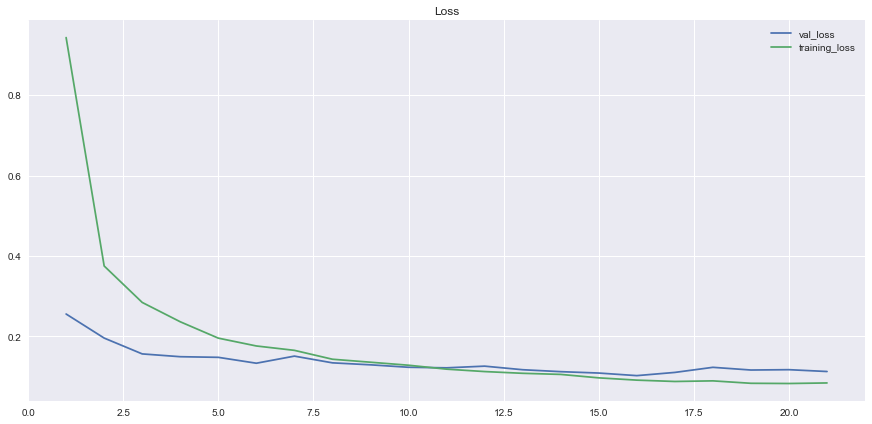

In [161]:
plt.figure(figsize=(15, 7))
epochs=range(1, len(nn_model.history.history['loss'])+1)
plt.plot(epochs, nn_model.history.history['val_loss'])
plt.plot(epochs, nn_model.history.history['loss'])
plt.legend(['val_loss', 'training_loss'])
plt.title('Loss')
# We see that as the models goes through more epochs the two curves start to converge. This means that the model is fitting
# the training and test set effienctly and this is model is fit for our predictions

In [131]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

#convert each text in dataset to sequence of integers
token.fit_on_texts(list(X_train) + list(X_test))
X_train_seq = token.texts_to_sequences(X_train)
X_test_seq = token.texts_to_sequences(X_test)

# zero pad the sequences
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=max_len)


word_index = token.word_index

In [132]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = glove_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


100%|███████████████████████████████████████████████████████████████████████████| 26054/26054 [01:09<00:00, 375.92it/s]


In [167]:
# A simple bidirectional LSTM with glove embeddings As the dataset is not large it is important to add dropout to avoid overfitting
# The embedding size is 300 the the input lenght is 70. 
def bilstm():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                         300,
                         weights=[embedding_matrix],
                         input_length=max_len,
                         trainable=False))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(24))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

In [168]:
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
model=bilstm()
          verbose=1, validation_data=(X_test_pad, y_test_enc), callbacks=[earlystop])

Train on 16637 samples, validate on 2936 samples
Epoch 1/100
16637/16637 [==============================] - ETA: 3:44 - loss: 3.183 - ETA: 2:04 - loss: 3.027 - ETA: 1:30 - loss: 2.909 - ETA: 1:13 - loss: 2.812 - ETA: 1:02 - loss: 2.768 - ETA: 55s - loss: 2.734 - ETA: 49s - loss: 2.69 - ETA: 45s - loss: 2.67 - ETA: 41s - loss: 2.64 - ETA: 38s - loss: 2.62 - ETA: 35s - loss: 2.60 - ETA: 32s - loss: 2.58 - ETA: 30s - loss: 2.58 - ETA: 28s - loss: 2.56 - ETA: 26s - loss: 2.56 - ETA: 24s - loss: 2.55 - ETA: 22s - loss: 2.54 - ETA: 20s - loss: 2.54 - ETA: 19s - loss: 2.53 - ETA: 17s - loss: 2.53 - ETA: 15s - loss: 2.53 - ETA: 14s - loss: 2.52 - ETA: 12s - loss: 2.51 - ETA: 11s - loss: 2.51 - ETA: 10s - loss: 2.51 - ETA: 8s - loss: 2.5069 - ETA: 7s - loss: 2.505 - ETA: 5s - loss: 2.501 - ETA: 4s - loss: 2.501 - ETA: 3s - loss: 2.500 - ETA: 1s - loss: 2.500 - ETA: 0s - loss: 2.500 - 45s 3ms/step - loss: 2.4983 - val_loss: 2.4536
Epoch 2/100
16637/16637 [==============================] - ETA: 3

ResourceExhaustedError: OOM when allocating tensor with shape[1024,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_13/Adam/Square_14}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [62]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 70, 300)           7726200   
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 70, 300)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              205824    
_________________________________________________________________
dropout_22 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_23 (Dropout)         (None, 1024)              0         
__________

In [63]:
#prediction
y_pred=model.predict(X_test_pad)
print ("logloss: %0.3f " % multiclass_logloss(y_test, y_pred))
print(metrics.classification_report (y_test, np.argmax(y_pred, axis = 1)))

logloss: 0.133 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       157
           1       0.84      0.84      0.84        67
           2       0.89      0.97      0.93        34
           3       0.99      0.94      0.97       103
           4       0.93      0.93      0.93        14
           5       0.99      0.99      0.99       936
           6       0.95      0.98      0.97        99
           7       1.00      0.98      0.99       168
           8       0.96      0.93      0.95        28
           9       0.94      0.95      0.94       134
          10       0.94      0.93      0.93        96
          11       0.93      0.78      0.85        18
          12       0.98      1.00      0.99       524
          13       0.89      0.95      0.92        96
          14       0.98      0.98      0.98       165
          15       0.79      0.65      0.71        46
          16       1.00      0.81      0.90        32
          1

Text(0.5, 1.0, 'Loss')

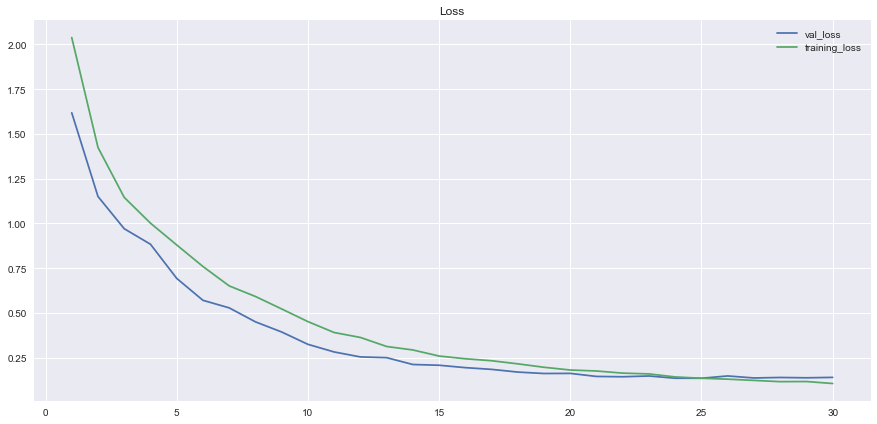

In [147]:
plt.figure(figsize=(15, 7))
epochs=range(1, len(model.history.history['loss'])+1)
plt.plot(epochs, model.history.history['val_loss'])
plt.plot(epochs, model.history.history['loss'])
plt.legend(['val_loss', 'training_loss'])
plt.title('Loss')

# We see that as the models goes through more epochs the two curves start to converge. This means that the model is fitting
# the training and test set effienctly and this is model is fit for our predictions

In [41]:
# GRU with glove embeddings using 4 layer deep dense layer. Aslo As the dataset is not 
# large it is important to add dropout to avoid overfitting

def GRU():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                         300,
                         weights=[embedding_matrix],
                         input_length=70,
                         trainable=False))
    model.add(SpatialDropout1D(0.3))
    model.add(keras.layers.recurrent.GRU(300,dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
    model.add(keras.layers.recurrent.GRU(300, dropout=0.3, recurrent_dropout=0.3))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
  
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    

    model.add(Dense(20))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [47]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
gru=GRU()
gru.fit(X_train_pad, y=y_train_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(X_test_pad, y_test_enc), callbacks=[earlystop])

W0409 11:53:21.385446 16728 deprecation.py:323] From C:\Users\ASUS\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 16515 samples, validate on 2915 samples
Epoch 1/100
16515/16515 [==============================] - ETA: 20:36 - loss: 2.98 - ETA: 10:33 - loss: 2.79 - ETA: 7:02 - loss: 2.7918 - ETA: 5:16 - loss: 2.684 - ETA: 4:11 - loss: 2.620 - ETA: 3:28 - loss: 2.563 - ETA: 2:57 - loss: 2.491 - ETA: 2:33 - loss: 2.447 - ETA: 2:14 - loss: 2.403 - ETA: 1:58 - loss: 2.374 - ETA: 1:46 - loss: 2.330 - ETA: 1:35 - loss: 2.299 - ETA: 1:25 - loss: 2.268 - ETA: 1:17 - loss: 2.245 - ETA: 1:09 - loss: 2.227 - ETA: 1:03 - loss: 2.203 - ETA: 57s - loss: 2.187 - ETA: 51s - loss: 2.16 - ETA: 46s - loss: 2.15 - ETA: 41s - loss: 2.13 - ETA: 37s - loss: 2.12 - ETA: 33s - loss: 2.11 - ETA: 29s - loss: 2.10 - ETA: 25s - loss: 2.09 - ETA: 21s - loss: 2.07 - ETA: 18s - loss: 2.06 - ETA: 15s - loss: 2.05 - ETA: 12s - loss: 2.04 - ETA: 9s - loss: 2.0387 - ETA: 6s - loss: 2.033 - ETA: 3s - loss: 2.028 - ETA: 0s - loss: 2.017 - 104s 6ms/step - loss: 2.0158 - val_loss: 1.6781
Epoch 2/100
16515/16515 [================

16515/16515 [==============================] - ETA: 46s - loss: 0.30 - ETA: 45s - loss: 0.28 - ETA: 43s - loss: 0.30 - ETA: 42s - loss: 0.31 - ETA: 40s - loss: 0.31 - ETA: 39s - loss: 0.32 - ETA: 37s - loss: 0.31 - ETA: 36s - loss: 0.31 - ETA: 34s - loss: 0.31 - ETA: 33s - loss: 0.30 - ETA: 31s - loss: 0.30 - ETA: 30s - loss: 0.30 - ETA: 28s - loss: 0.31 - ETA: 27s - loss: 0.30 - ETA: 25s - loss: 0.30 - ETA: 24s - loss: 0.30 - ETA: 22s - loss: 0.30 - ETA: 21s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 18s - loss: 0.30 - ETA: 16s - loss: 0.30 - ETA: 15s - loss: 0.30 - ETA: 13s - loss: 0.30 - ETA: 12s - loss: 0.30 - ETA: 10s - loss: 0.30 - ETA: 9s - loss: 0.3042 - ETA: 7s - loss: 0.302 - ETA: 6s - loss: 0.301 - ETA: 4s - loss: 0.300 - ETA: 3s - loss: 0.302 - ETA: 1s - loss: 0.301 - ETA: 0s - loss: 0.300 - 51s 3ms/step - loss: 0.3009 - val_loss: 0.2331
Epoch 11/100
16515/16515 [==============================] - ETA: 46s - loss: 0.33 - ETA: 45s - loss: 0.29 - ETA: 43s - loss: 0.28 - ETA: 

16515/16515 [==============================] - ETA: 46s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 40s - loss: 0.18 - ETA: 39s - loss: 0.19 - ETA: 37s - loss: 0.18 - ETA: 36s - loss: 0.18 - ETA: 34s - loss: 0.18 - ETA: 33s - loss: 0.18 - ETA: 31s - loss: 0.18 - ETA: 30s - loss: 0.18 - ETA: 28s - loss: 0.17 - ETA: 27s - loss: 0.17 - ETA: 25s - loss: 0.17 - ETA: 24s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 21s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 18s - loss: 0.16 - ETA: 16s - loss: 0.16 - ETA: 15s - loss: 0.16 - ETA: 13s - loss: 0.16 - ETA: 12s - loss: 0.16 - ETA: 10s - loss: 0.16 - ETA: 9s - loss: 0.1605 - ETA: 7s - loss: 0.161 - ETA: 6s - loss: 0.161 - ETA: 4s - loss: 0.159 - ETA: 3s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 0s - loss: 0.159 - 51s 3ms/step - loss: 0.1596 - val_loss: 0.1356
Epoch 20/100
16515/16515 [==============================] - ETA: 46s - loss: 0.13 - ETA: 45s - loss: 0.12 - ETA: 43s - loss: 0.14 - ETA: 

16515/16515 [==============================] - ETA: 45s - loss: 0.09 - ETA: 44s - loss: 0.07 - ETA: 42s - loss: 0.08 - ETA: 41s - loss: 0.10 - ETA: 40s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 36s - loss: 0.09 - ETA: 34s - loss: 0.09 - ETA: 33s - loss: 0.09 - ETA: 32s - loss: 0.09 - ETA: 30s - loss: 0.09 - ETA: 29s - loss: 0.09 - ETA: 27s - loss: 0.09 - ETA: 26s - loss: 0.09 - ETA: 24s - loss: 0.09 - ETA: 23s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 17s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 9s - loss: 0.0998 - ETA: 7s - loss: 0.100 - ETA: 6s - loss: 0.101 - ETA: 4s - loss: 0.101 - ETA: 3s - loss: 0.101 - ETA: 1s - loss: 0.102 - ETA: 0s - loss: 0.102 - 52s 3ms/step - loss: 0.1022 - val_loss: 0.1249
Epoch 29/100
16515/16515 [==============================] - ETA: 46s - loss: 0.10 - ETA: 45s - loss: 0.08 - ETA: 44s - loss: 0.09 - ETA: 

In [98]:
gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 70, 300)           7726200   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 70, 300)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 70, 300)           540900    
_________________________________________________________________
gru_4 (GRU)                  (None, 300)               540900    
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              308224    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              1049600   
__________

In [50]:
#prediction
y_pred=gru.predict(X_test_pad)
print ("logloss: %0.3f " % multiclass_logloss(y_test, y_pred))
print(metrics.classification_report (y_test, np.argmax(y_pred, axis = 1)))

logloss: 0.123 
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       157
           1       0.89      0.88      0.89        67
           2       0.85      1.00      0.92        34
           3       0.96      0.92      0.94       103
           4       1.00      0.93      0.96        14
           5       0.99      0.99      0.99       936
           6       0.93      0.99      0.96        99
           7       1.00      1.00      1.00       168
           8       1.00      0.89      0.94        28
           9       0.99      1.00      0.99       134
          10       0.97      0.97      0.97        96
          11       0.86      0.67      0.75        18
          12       0.99      0.99      0.99       524
          13       0.86      0.99      0.92        96
          14       0.98      0.98      0.98       165
          15       0.86      0.65      0.74        46
          16       1.00      0.91      0.95        32
          1

Text(0.5, 1.0, 'Loss')

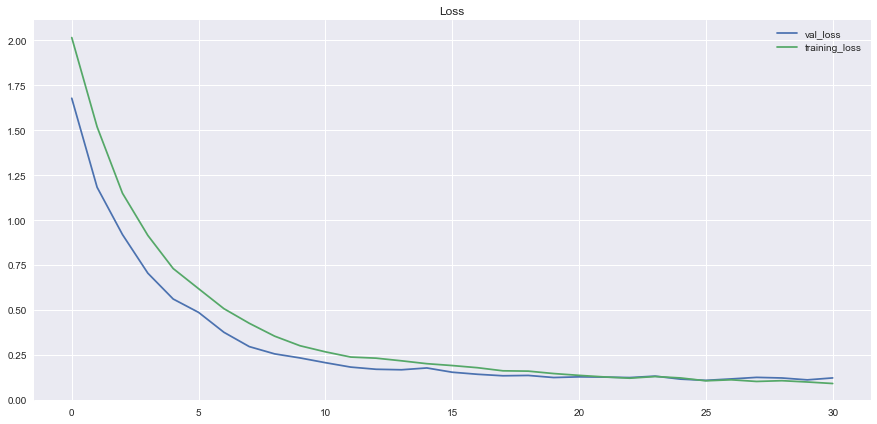

In [103]:
plt.figure(figsize=(15, 7))
epochs=range(1, len(gru.history.history['loss'])+1)
plt.plot(epochs), gru.history.history['val_loss'])
plt.plot(epochs, gru.history.history['loss'])
plt.legend(['val_loss', 'training_loss'])
plt.title('Loss')

# We see that as the models goes through more epochs the two curves start to converge. This means that the model is fitting
# the training and test set effienctly and this is model is fit for our predictions